In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders
from classes.model_pipeline import OptimalRegressionPipeline, OptimalClassificationPipeline
from classes.baseline_models import MeanBaselineModel, MajorityBaselineModel, RandomBaselineModel

import warnings
warnings.simplefilter('ignore')
load_dotenv();

In [3]:
df = pd.read_pickle(os.path.join('datasets', "new_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 3621 songs


,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [5]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['unique_word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'noun_ratio',
       'verb_ratio', 'vader_compound', 'repetition_count', 'language', 'genre',
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density', 'sentiment_variability', 'linguistic_uniqueness',
       'flesch_reading_ease', 'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]

w2v_features = [ f for f in df.columns if f.startswith("w2v") ]

empath_features = [ f for f in df.columns if f.startswith("empath") ]

audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']


---

# Classification

In [6]:
df.explicit.value_counts()

explicit
0    3023
1     598
Name: count, dtype: int64

In [49]:
df.explicit.value_counts(normalize=True)

explicit
0    0.834852
1    0.165148
Name: proportion, dtype: float64

## Prediction with all features

In [7]:
target = 'explicit'
features = [ f for f in spotify_features + lyrics_features + tfidf_features + w2v_features + empath_features + audio_extracted_features if f in df.columns ]

In [8]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [9]:
cat_features

['key', 'mode', 'time_signature', 'language', 'genre']

In [10]:
len(num_features)

458

In [11]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: explicit
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['chroma_7',
                                                                    'empath_sleep',
                                                                    'w2v_57',
                                                                    'tfidf_72',
                                                                    'unique_word_count',
                                                                    'empath_government',
                                                                    'empath_occupation',
                                                                    'empath_office',
                                                                    'mfcc_9',...
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['time_signature',
                                                                    'mode',
                                                                    'language',
                                                                    'genre',
                                                                    'key'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x7b53fffeb910>)])

In [12]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-19 22:27:36,395] A new study created in RDB with name: catboost_explicit
[I 2024-12-19 22:28:52,811] Trial 4 finished with value: 0.9228813314942641 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.09903450142321706, 'l2_leaf_reg': 3.3543110874443167}. Best is trial 4 with value: 0.9228813314942641.
[I 2024-12-19 22:30:16,664] Trial 3 finished with value: 0.9229386771470148 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.07411858233867076, 'l2_leaf_reg': 9.703007073592943}. Best is trial 3 with value: 0.9229386771470148.
[I 2024-12-19 22:30:17,704] Trial 0 finished with value: 0.9220147177817968 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.08769998787705016, 'l2_leaf_reg': 1.0261104434687778}. Best is trial 3 with value: 0.9229386771470148.
[I 2024-12-19 22:30:20,881] Trial 1 finished with value: 0.9266078488980266 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.08077943536039671, 'l2_leaf_reg': 

INFO: Pipeline training completed.


In [13]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.928
1,F1 Score,0.927
2,Precision,0.927
3,Recall,0.928


INFO: Evaluating the model...


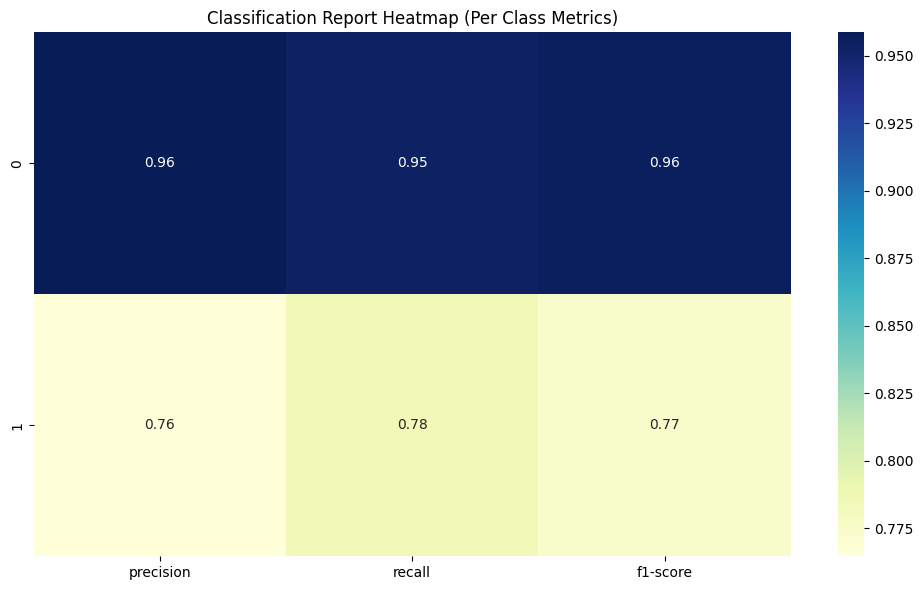

,precision,recall,f1-score,support
0,0.958746,0.954023,0.956379,609.000000
1,0.764706,0.784483,0.774468,116.000000
accuracy,0.926897,0.926897,0.926897,0.926897
macro avg,0.861726,0.869253,0.865423,725.000000
weighted avg,0.927699,0.926897,0.927273,725.000000


In [14]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


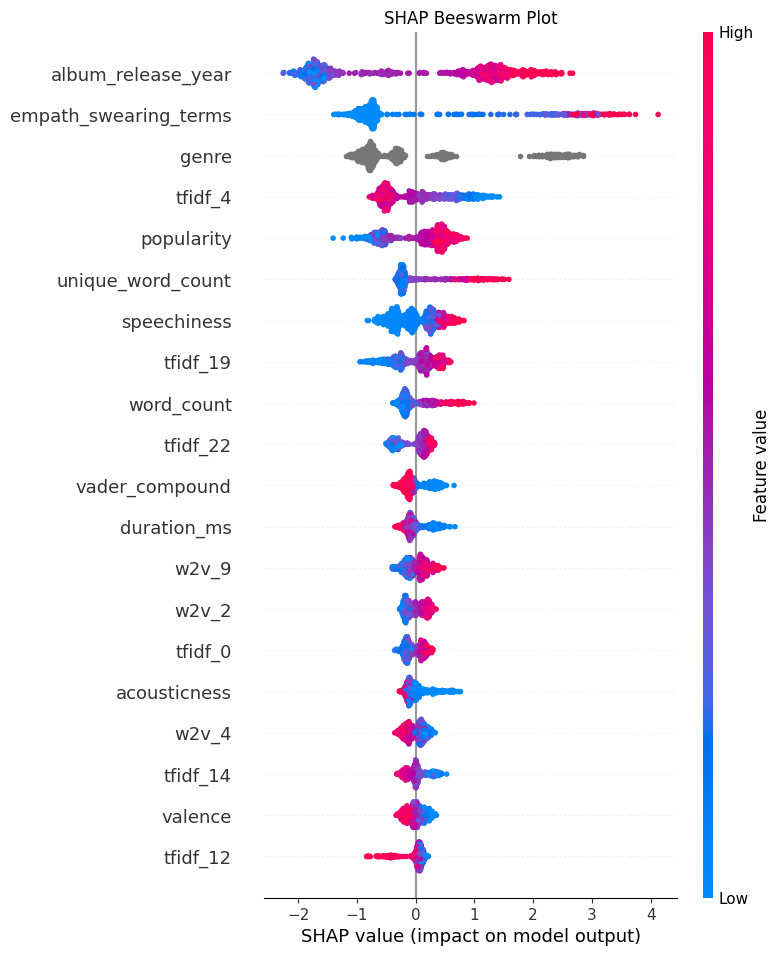

INFO: Generating feature importance bar plot...


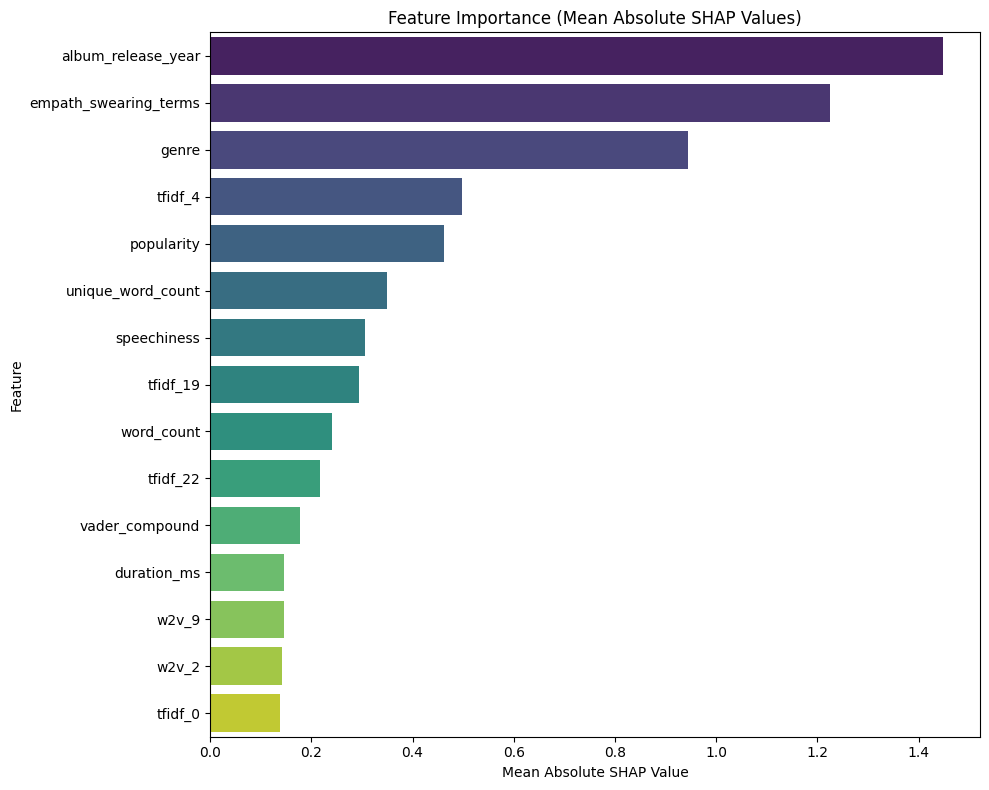

In [15]:
pipeline.perform_shap_analysis()

## Prediction with lyrics

In [16]:
target = 'explicit'
features = [ f for f in lyrics_features + tfidf_features + w2v_features + empath_features if f in df.columns ]

In [17]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [18]:
cat_features

['language', 'genre']

In [19]:
len(num_features)

412

In [20]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: explicit
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['empath_sleep',
                                                                    'w2v_57',
                                                                    'tfidf_72',
                                                                    'unique_word_count',
                                                                    'empath_government',
                                                                    'empath_occupation',
                                                                    'empath_office',
                                                                    'w2v_12',
                                                                    'w2v_77',
                                                                    'e...
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['genre',
                                                                    'language'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x7b53ecbc96c0>)])

In [21]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-19 22:38:29,029] Using an existing study with name 'catboost_explicit' instead of creating a new one.
[I 2024-12-19 22:52:06,215] Trial 11 finished with value: 0.916832095739642 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.04602418472169123, 'l2_leaf_reg': 3.049747193014171}. Best is trial 7 with value: 0.9267872093333624.
[I 2024-12-19 22:52:22,620] Trial 14 finished with value: 0.9175549582987582 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.0431558466759384, 'l2_leaf_reg': 3.4000851205198765}. Best is trial 7 with value: 0.9267872093333624.
[I 2024-12-19 22:52:35,366] Trial 16 finished with value: 0.919089428139786 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.04744153107810669, 'l2_leaf_reg': 3.1101844956547984}. Best is trial 7 with value: 0.9267872093333624.
[I 2024-12-19 22:52:38,255] Trial 12 finished with value: 0.9161569899807025 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.04

INFO: Pipeline training completed.


In [22]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.923
1,F1 Score,0.921
2,Precision,0.920
3,Recall,0.923


INFO: Evaluating the model...


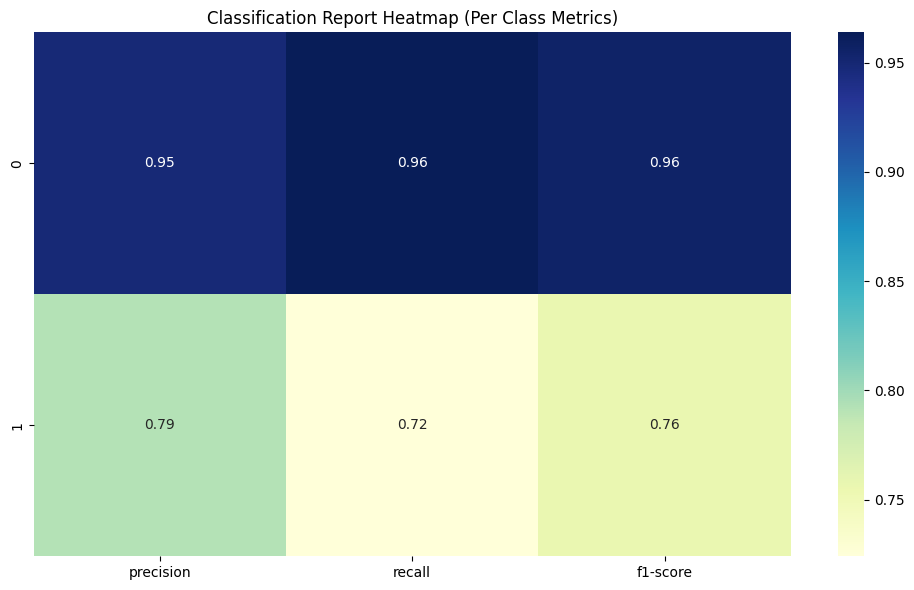

,precision,recall,f1-score,support
0,0.948304,0.963875,0.956026,609.000000
1,0.792453,0.724138,0.756757,116.000000
accuracy,0.925517,0.925517,0.925517,0.925517
macro avg,0.870378,0.844007,0.856391,725.000000
weighted avg,0.923368,0.925517,0.924143,725.000000


In [23]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


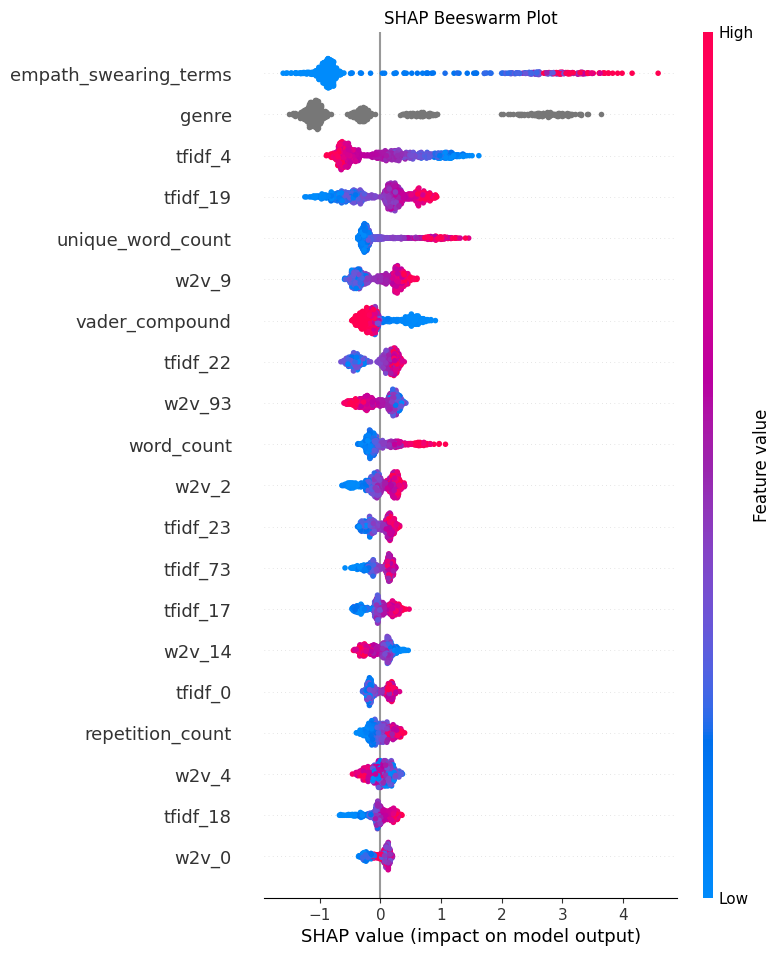

INFO: Generating feature importance bar plot...


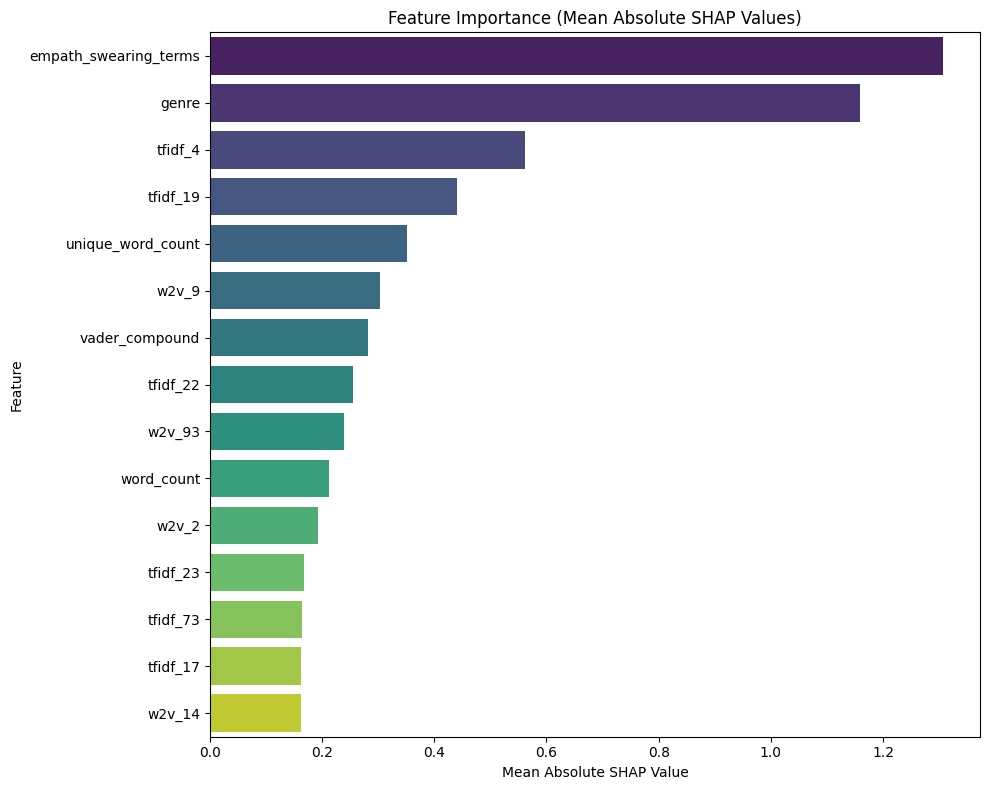

In [24]:
pipeline.perform_shap_analysis()

## Prediction with Spotify Features

In [25]:
target = 'explicit'
features = [ f for f in spotify_features if f in df.columns ]

In [26]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [27]:
cat_features

['key', 'mode', 'time_signature']

In [28]:
len(num_features)

12

In [29]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: explicit
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['album_release_year',
                                                                    'duration_ms',
                                                                    'acousticness',
                                                                    'speechiness',
                                                                    'valence',
                                                                    'tempo',
                                                                    'instrumentalness',
                                                                    'liveness',
                                                                    'danceability',
                                                                    'ene...
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['mode',
                                                                    'key',
                                                                    'time_signature'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x7b53ec40a140>)])

In [30]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-19 22:55:59,953] Using an existing study with name 'catboost_explicit' instead of creating a new one.
[I 2024-12-19 22:56:10,866] Trial 24 finished with value: 0.8389739083573048 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.030758855211247806, 'l2_leaf_reg': 1.907798803127319}. Best is trial 7 with value: 0.9267872093333624.
[I 2024-12-19 22:56:11,515] Trial 22 finished with value: 0.8372542185093325 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.026936450275103507, 'l2_leaf_reg': 2.003174555629215}. Best is trial 7 with value: 0.9267872093333624.
[I 2024-12-19 22:56:11,520] Trial 27 finished with value: 0.8275120418399904 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.01894152038083305, 'l2_leaf_reg': 2.0690750055842484}. Best is trial 7 with value: 0.9267872093333624.
[I 2024-12-19 22:56:11,536] Trial 21 finished with value: 0.8309775292813422 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.02

INFO: Pipeline training completed.


In [31]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.854
1,F1 Score,0.855
2,Precision,0.856
3,Recall,0.854


INFO: Evaluating the model...


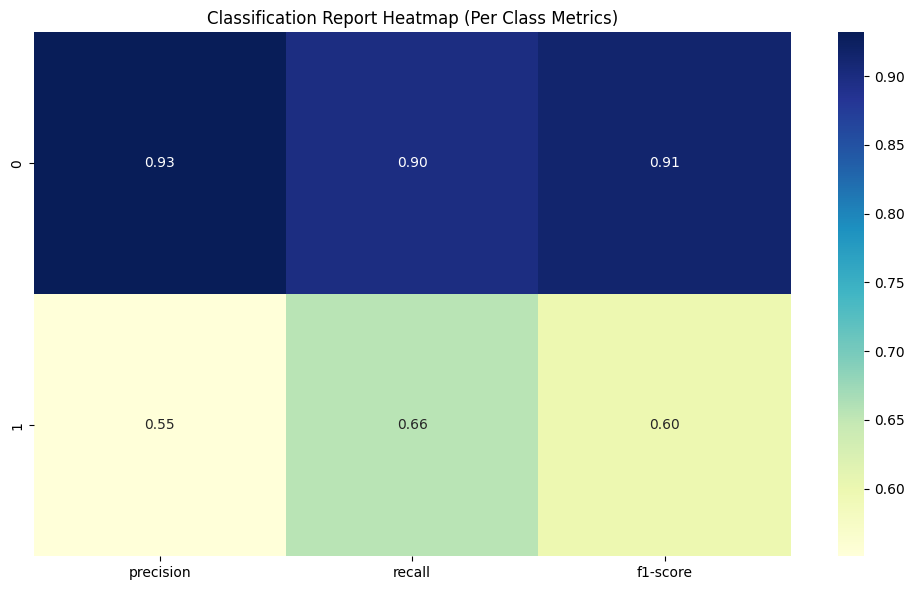

,precision,recall,f1-score,support
0,0.931857,0.898194,0.914716,609.00000
1,0.550725,0.655172,0.598425,116.00000
accuracy,0.859310,0.859310,0.859310,0.85931
macro avg,0.741291,0.776683,0.756570,725.00000
weighted avg,0.870876,0.859310,0.864109,725.00000


In [32]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


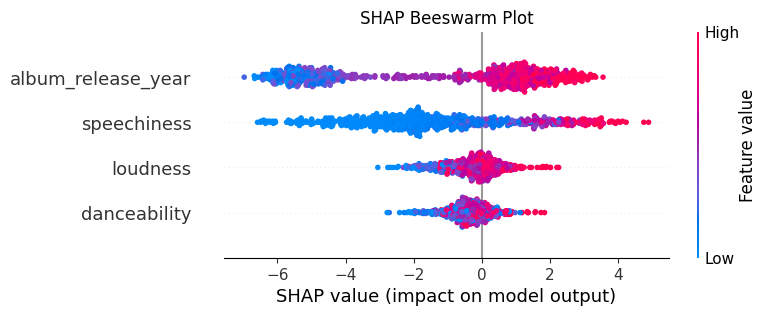

INFO: Generating feature importance bar plot...


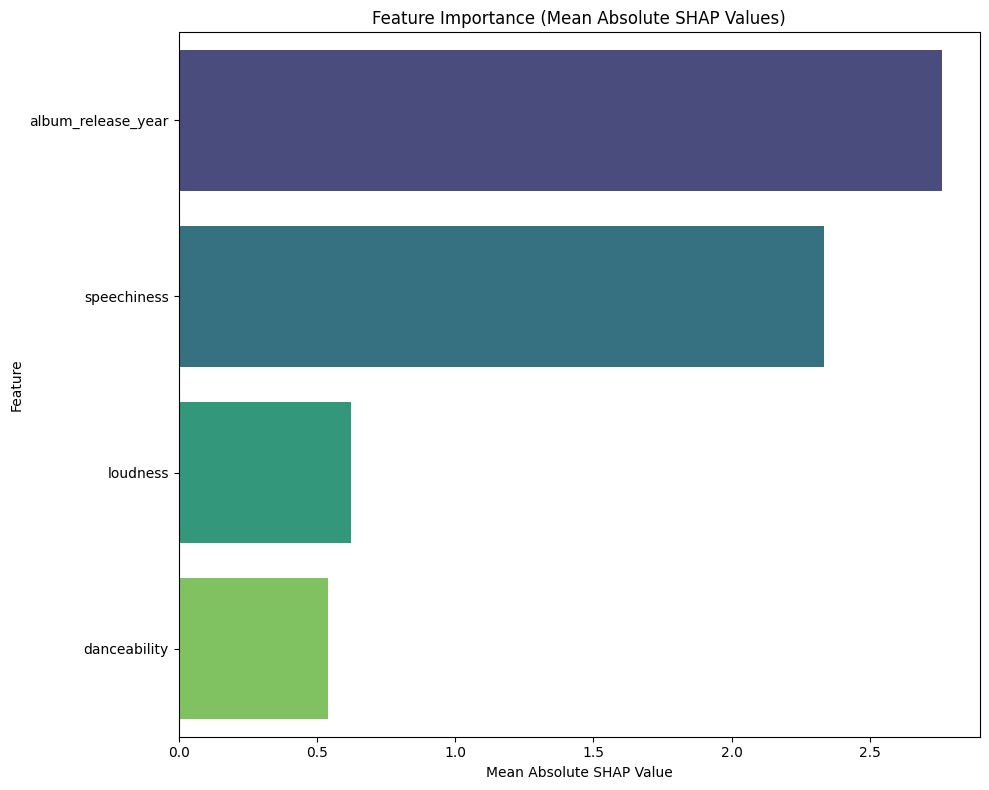

In [33]:
pipeline.perform_shap_analysis()

## Prediction with Audio Features

In [34]:
target = 'explicit'
features = [ f for f in audio_extracted_features if f in df.columns ]

In [35]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [36]:
cat_features

[]

In [37]:
len(num_features)

34

In [38]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: explicit
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['chroma_7',
                                                                    'chroma_3',
                                                                    'mfcc_13',
                                                                    'spectral_contrast_5',
                                                                    'mfcc_11',
                                                                    'chroma_9',
                                                                    'spectral_contrast_4',
                                                                    'mfcc_12',
                                                                    'mfcc_8',
                                                                    'spectral_contr...
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   [])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x7b53ec409d20>)])

In [39]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-19 22:56:37,003] Using an existing study with name 'catboost_explicit' instead of creating a new one.
[I 2024-12-19 22:56:58,492] Trial 32 finished with value: 0.8115496236294291 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.06343170925478524, 'l2_leaf_reg': 9.881837034717838}. Best is trial 7 with value: 0.9267872093333624.
[I 2024-12-19 22:56:59,289] Trial 35 finished with value: 0.8092494810829294 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.06395112198838672, 'l2_leaf_reg': 9.942123528204174}. Best is trial 7 with value: 0.9267872093333624.
[I 2024-12-19 22:56:59,636] Trial 33 finished with value: 0.8091805495296234 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.06369627481849094, 'l2_leaf_reg': 4.2990629667277025}. Best is trial 7 with value: 0.9267872093333624.
[I 2024-12-19 22:57:00,170] Trial 37 finished with value: 0.8098295910152775 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.

INFO: Pipeline training completed.


In [40]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.834
1,F1 Score,0.824
2,Precision,0.818
3,Recall,0.834


INFO: Evaluating the model...


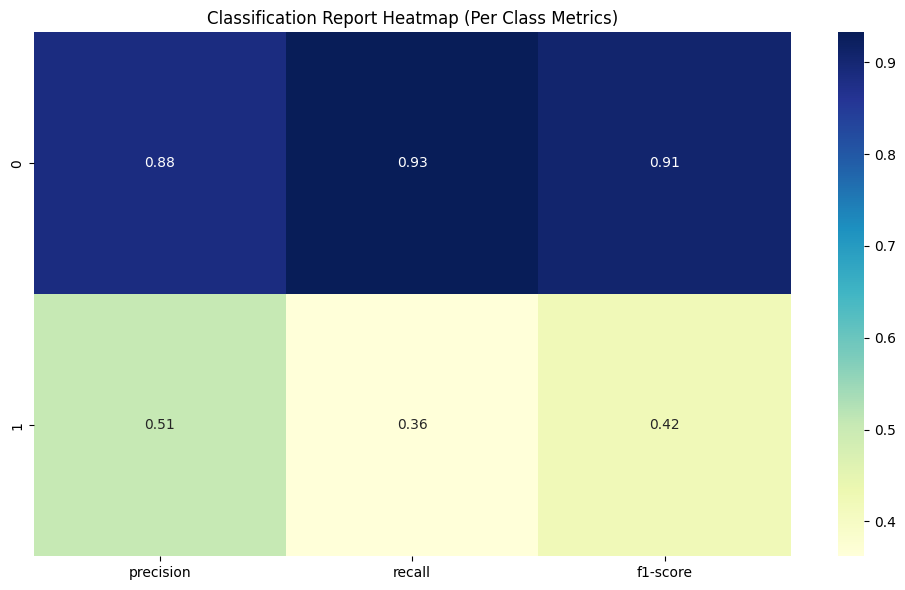

,precision,recall,f1-score,support
0,0.884735,0.932677,0.908074,609.000000
1,0.506024,0.362069,0.422111,116.000000
accuracy,0.841379,0.841379,0.841379,0.841379
macro avg,0.695380,0.647373,0.665092,725.000000
weighted avg,0.824141,0.841379,0.830319,725.000000


In [41]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


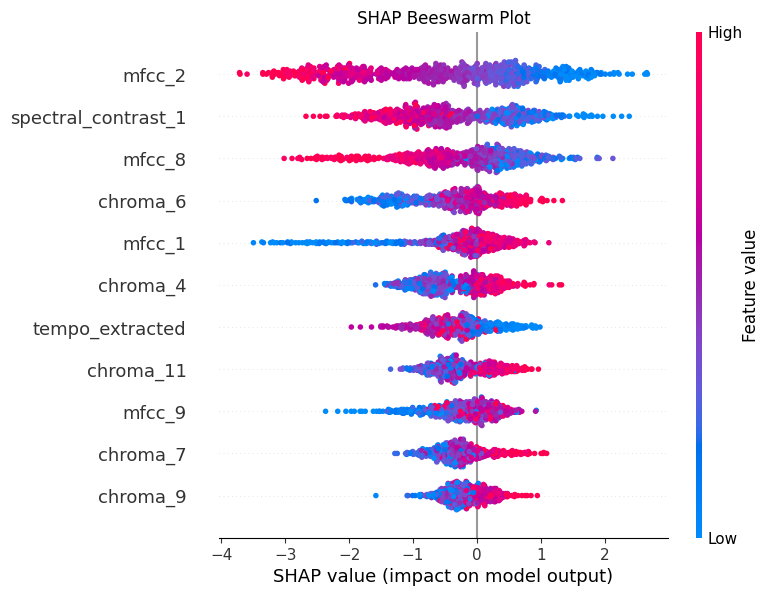

INFO: Generating feature importance bar plot...


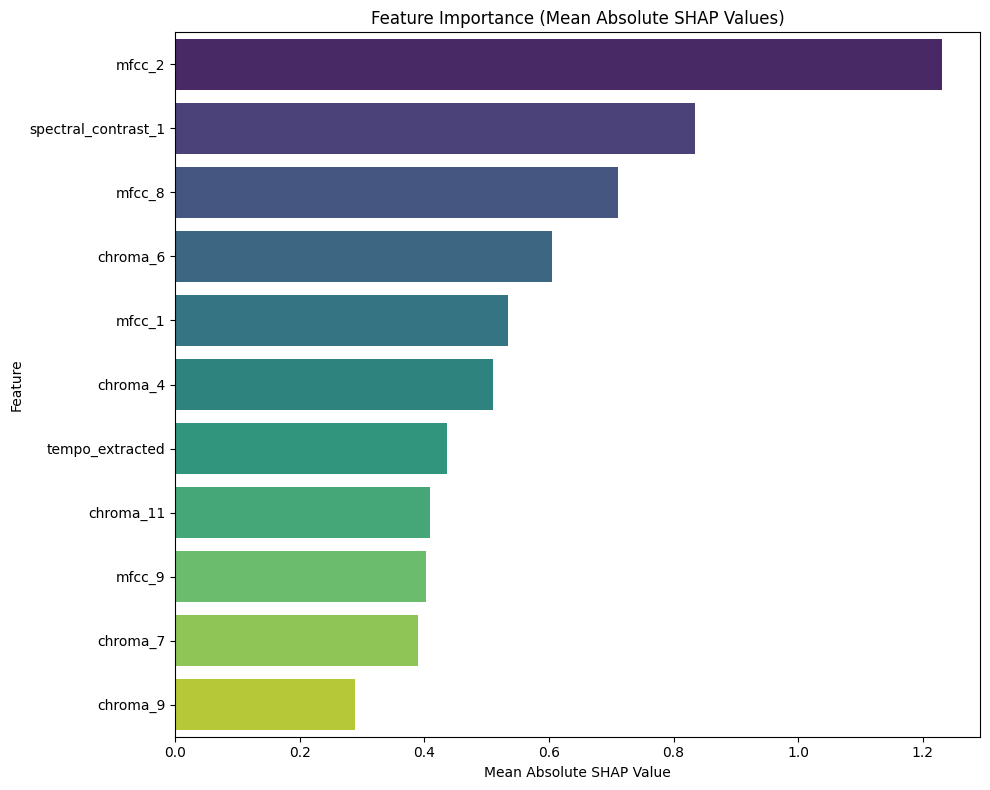

In [42]:
pipeline.perform_shap_analysis()

## Baseline

In [43]:
majority_model = MajorityBaselineModel()
majority_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = majority_model.predict(pipeline.X_test)
majority_model.evaluate(pipeline.y_test, y_pred)

,Score
Accuracy,0.840000
Precision,0.705600
Recall,0.840000
F1 Score,0.766957


In [44]:
random_model = RandomBaselineModel()
random_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = random_model.predict(pipeline.X_test)
random_model.evaluate(pipeline.y_test, y_pred)

,Score
Accuracy,0.500690
Precision,0.735199
Recall,0.500690
F1 Score,0.565702


In [46]:
df.popularity.mean()

58.94283347141673